**Загрузка данных**

In [2]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
from phik.report import plot_correlation_matrix

In [3]:
df = pd.read_csv('kicksharing.csv')
df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690479,2024-08-07 09:47:25.000000,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,NaN
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.114912,2024-10-17 14:57:20.000000,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30,NaN
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,1.515612,2024-09-19 05:31:41.000000,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79,NaN
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.499411,2024-10-04 16:05:09.000000,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70,NaN
4,258647149,238473615,M,34,NaN,NaN,Г МОСКВА,6.99,50.0,300.0,SL,2.602028,2024-07-10 06:57:40.000000,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38,NaN


**Изучение данных**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_rk                 396749 non-null  int64  
 1   party_rk                 396749 non-null  int64  
 2   gender_cd                393828 non-null  object 
 3   age                      396749 non-null  int64  
 4   education_level_cd       190059 non-null  object 
 5   marital_status_cd        217729 non-null  object 
 6   lvn_state_nm             362572 non-null  object 
 7   minute_cost              396749 non-null  float64
 8   activation_cost          396749 non-null  float64
 9   hold_amount              396749 non-null  float64
 10  transport_model          396749 non-null  object 
 11  distance_km              396749 non-null  float64
 12  created_dttm             396749 non-null  object 
 13  book_start_dttm          396749 non-null  object 
 14  book

Смотрим имнформацию по типу данных.

Можно изменить тип данных столбцов "gender_cd", "education_level_cd", "marital_status_cd" на категорию, чтобы снизить количество занимаемой памяти.
Заменим тип данных столбцов "created_dttm", "book_start_dttm", "book_start_dttm", "book_end_dttm", "local_book_start_dttm" на дату и время.

In [5]:
df.isnull().sum()

order_rk                        0
party_rk                        0
gender_cd                    2921
age                             0
education_level_cd         206690
marital_status_cd          179020
lvn_state_nm                34177
minute_cost                     0
activation_cost                 0
hold_amount                     0
transport_model                 0
distance_km                     0
created_dttm                    0
book_start_dttm                 0
book_end_dttm                   0
book_time_zone_cd               0
local_book_start_dttm           0
nominal_price_rub_amt           0
loyalty_accrual_rub_amt     29757
loyalty_accrual_bns_amt    374801
dtype: int64

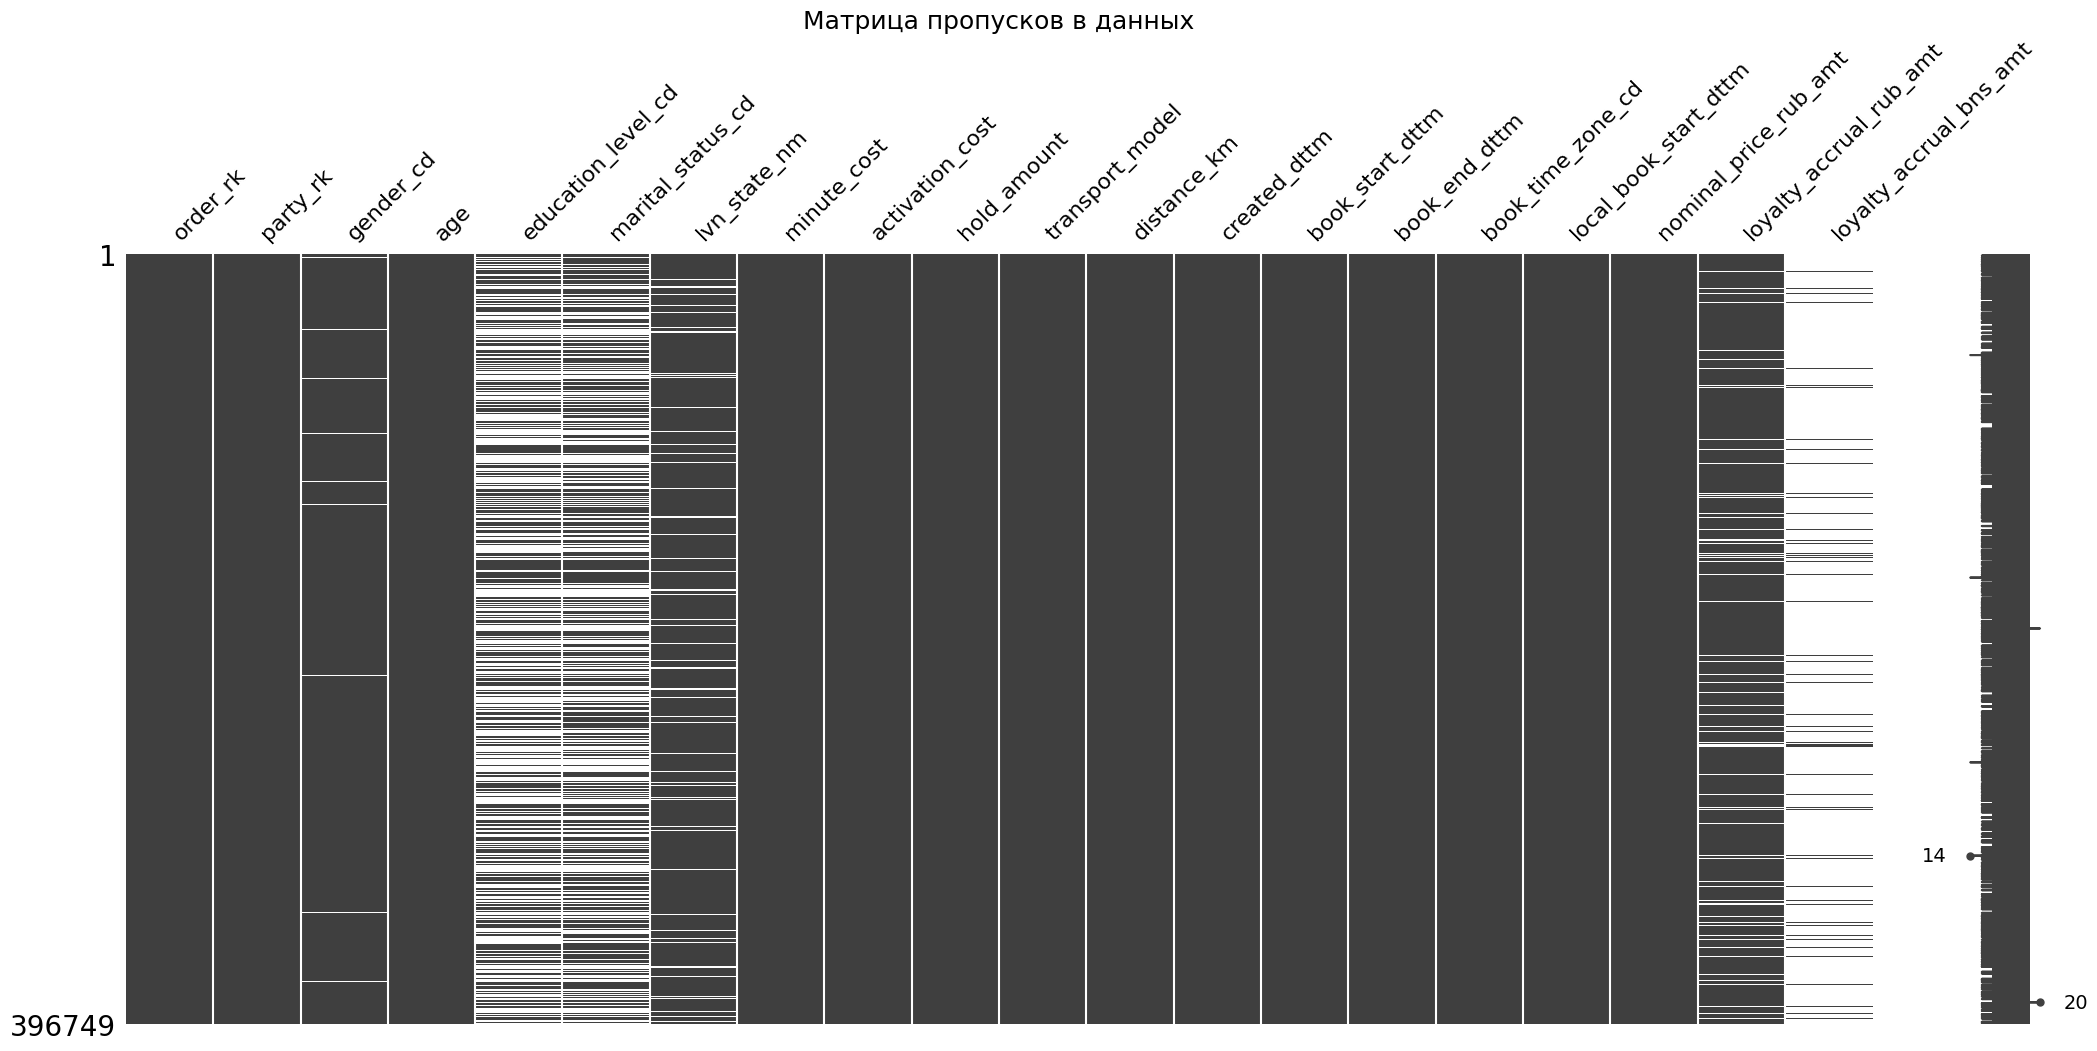

In [6]:
msno.matrix(df)
plt.title('Матрица пропусков в данных', fontsize = 18)
plt.show()

Смотрим информацию по пропускам.

gender_cd - так как пропусков достаточно много, это будет стобец с категориями, то будем заполнять модой.

education_level_cd и marital_status_cd - имеют большую часть пропусков, примерно до 1/2 от общего числа данных, также эта информация, которая не является основной для нашего сервиса, поэтому данные столюцы мы можем оставить без заполнения.

lvn_state_nm - заполним исходя из предположения о часовом поясе "book_time_zone_cd"

loyalty_accrual_rub_amt - пропусков относительно немного, у нас числовой тип данных, поэтому можем заполнить медианой.

loyalty_accrual_bns_amt - почти все строки пропущены, поэтому оставим данный стобец без заполнения.

In [7]:
# Проводим первоначальный анализ данных, уберем столбцы с идентификаторами, чтобы они нам не мешали в восприятии информации 
df.drop(columns = ['order_rk', 'party_rk']).describe().round(2)

,age,minute_cost,activation_cost,hold_amount,distance_km,book_time_zone_cd,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
count,396749.00,396749.00,396749.00,396749.00,396749.00,396749.00,396749.00,366992.00,21948.00
mean,31.54,7.29,42.59,299.98,3.68,3.54,127.65,37.52,127.79
std,9.43,1.29,11.99,1.94,141.86,1.21,100.12,75.21,496.81
min,12.00,1.50,0.00,80.00,0.00,0.00,0.00,-161.94,1.00
25%,24.00,6.49,30.00,300.00,0.94,3.00,80.84,11.24,43.00
50%,31.00,7.49,50.00,300.00,1.73,3.00,103.94,18.73,62.00
75%,37.00,8.22,50.00,300.00,3.06,3.00,142.10,35.06,81.00
max,94.00,19.99,50.00,500.00,56012.64,12.00,5627.64,3185.00,55429.36


Можем сделать уже первичный предположительный анализ данных по имеющейся описательной статистике. Скорее всего, данные  по возрасту, стоимости за минуту, стоимости активации, стоимости заморозки будут нормально распределены, т.к. медиана и 2й квартиль примерно одинаковые. В стобце "age" необходимо перепроверить информацию, потому что максимальный возраст равен 94 годам, что достаточно много для водителя самоката. В столбце "distance_km" - есть сильные выбросы, мин 0 км - это может быть связано с тем, что человек взял в аренду самокат, но не смог на нем уехать, и макс 56012,64 км - возможно, это ошибка в единицах измерения или опечатка. Также есть большие выбросы в стобце "nominal_price_rub_amt", мин - 0, может быть связан с тем, что человек так и не совершил поездку на самокате, а макс - 5627.64 скорее связан опять же с опечаткой, либо ошибкой в списании средств (предполагаю, что кто-то воспользовался арендой самоката, но не завершил ее, поэтому ездили на самокате уже другие пользователи, а платил один человек). Также есть экстримально низкие и высокие значения в "loyalty_accrual_rub_amt" - отрицательные значения скорее связаны с тем, что человек нарушал правила пользования сервисом и у него забирали кэшбек, а экстримально высокий связан, возможно, с возвратом средств. Также есть выброс в стобце "loyalty_accrual_bns_amt", возможно, аномально большое значение связано с опечаткой. 

In [8]:
# Смотрим анализ нечисловых столбцов
df.describe(include = ['object'])

,gender_cd,education_level_cd,marital_status_cd,lvn_state_nm,transport_model,created_dttm,book_start_dttm,book_end_dttm,local_book_start_dttm
count,393828,190059,217729,362572,396749,396749,396749,396749,396749
unique,2,5,5,212,14,387224,396745,396749,396746
top,M,GRD,UNM,Г МОСКВА,SL,2024-09-12 15:15:50.000000,2024-09-17 13:44:24.183000,2024-08-07 10:07:59.339524,2024-09-17 13:44:24.183000
freq,335458,94341,116094,90897,241247,4,2,1,2


**Обработка данных**

In [9]:
# Приступаем к замене типа данных 

# Замена на категориальный тип данных 
object_col = ['gender_cd', 'education_level_cd', 'marital_status_cd']

for col in object_col:
    df[col] = df[col].astype('category')

# Замена на дату и время
date_col = ['created_dttm', 'book_start_dttm', 'book_end_dttm', 'local_book_start_dttm']

for col in date_col:
    df[col] = pd.to_datetime(df[col], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   order_rk                 396749 non-null  int64         
 1   party_rk                 396749 non-null  int64         
 2   gender_cd                393828 non-null  category      
 3   age                      396749 non-null  int64         
 4   education_level_cd       190059 non-null  category      
 5   marital_status_cd        217729 non-null  category      
 6   lvn_state_nm             362572 non-null  object        
 7   minute_cost              396749 non-null  float64       
 8   activation_cost          396749 non-null  float64       
 9   hold_amount              396749 non-null  float64       
 10  transport_model          396749 non-null  object        
 11  distance_km              396749 non-null  float64       
 12  created_dttm    

In [149]:
# Производим замену пропусков

# Столбец "gender_cd" заменяем модой
gender_cd_mode = df['gender_cd'].mode()[0]
df['gender_cd'] = df['gender_cd'].fillna(gender_cd_mode)

# Столбец "loyalty_accrual_rub_amt" заполняем медианой
rub_amt_median = df['loyalty_accrual_rub_amt'].median()
df['loyalty_accrual_rub_amt'] = df['loyalty_accrual_rub_amt'].fillna(rub_amt_median)


# Столбец "lvn_state_nm" заполним исходя из предположений о часовом поясе "book_time_zone_cd" 
# Сделаем словарь, в который включим самые часто встречающиеся города из датаврейма в каждом часовом поясе. 
# Далее будем заполнять пропуски в столюбце "lvn_state_nm", опираясь на этот словарь. 
grouped_state = df.groupby('book_time_zone_cd')['lvn_state_nm'].agg(
    lambda x: x.mode().iloc[0]).to_dict()

df['lvn_state_nm'] = df['lvn_state_nm'].fillna(df['book_time_zone_cd'].map(grouped_state))

df.isnull().sum()

order_rk                        0
party_rk                        0
gender_cd                       0
age                             0
education_level_cd         206690
marital_status_cd          179020
lvn_state_nm                    0
minute_cost                     0
activation_cost                 0
hold_amount                     0
transport_model                 0
distance_km                     0
created_dttm                    0
book_start_dttm                 0
book_end_dttm                   0
book_time_zone_cd               0
local_book_start_dttm           0
nominal_price_rub_amt           0
loyalty_accrual_rub_amt         0
loyalty_accrual_bns_amt    374801
dtype: int64

In [10]:
# Проводим повторный анализ описательной статистики после изменения типа данных и работы с пропусками
# Уберем столбцы с идентификаторами и временем для удобства
df_for_analysis = df.drop(columns = ['order_rk', 'party_rk', 'created_dttm', 'book_start_dttm', 'book_end_dttm', 'local_book_start_dttm', 
                                    'book_time_zone_cd'])
df_for_analysis.describe().round(2)

,age,minute_cost,activation_cost,hold_amount,distance_km,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
count,396749.00,396749.00,396749.00,396749.00,396749.00,396749.00,366992.00,21948.00
mean,31.54,7.29,42.59,299.98,3.68,127.65,37.52,127.79
std,9.43,1.29,11.99,1.94,141.86,100.12,75.21,496.81
min,12.00,1.50,0.00,80.00,0.00,0.00,-161.94,1.00
25%,24.00,6.49,30.00,300.00,0.94,80.84,11.24,43.00
50%,31.00,7.49,50.00,300.00,1.73,103.94,18.73,62.00
75%,37.00,8.22,50.00,300.00,3.06,142.10,35.06,81.00
max,94.00,19.99,50.00,500.00,56012.64,5627.64,3185.00,55429.36


In [11]:
df.describe(include = ['object'])

,lvn_state_nm,transport_model
count,362572,396749
unique,212,14
top,Г МОСКВА,SL
freq,90897,241247


После изменения типов данных и работы с пропусками, показатели описательной статистики не изменились, что говорит о том, что мы правильно заполнили пропуски. 
Касаемо анализа столюцов с типом данных "object" можно сказать, что у наши самокаты популярны во многих городах страны (212 городов), среди них больше всего пользователей из Москвы, что достаточно логично, т.к. это самый крупный город России. Самая популярная марка модели - Sl - возможно, она является наиболее удобной и быстрой для потребителя и их количество также велико

**Визуализация и вывод**

In [12]:
# Проведем визуализиацию и полноценный анализ категориальных признаков
def plot_categ (df, col):
    fig, ax = plt.subplots(1, 1, figsize = (8, 6))  
    sns.countplot(x = col, data = df, ax = ax, order = df[col].value_counts().index)
    ax.set_title(f'Распределение по признаку {col}', fontsize = 14)  
    ax.tick_params(axis = 'x', rotation = 45)
    plt.tight_layout()
    plt.show()

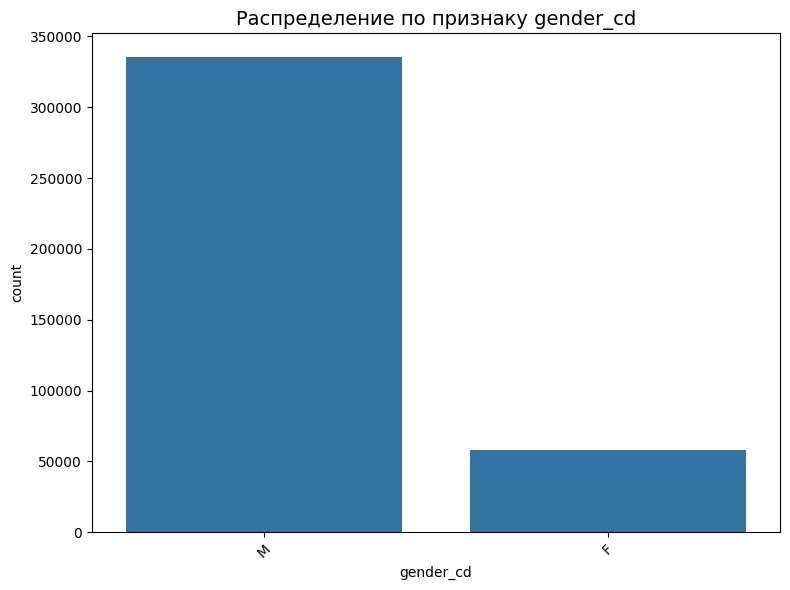

In [13]:
plot_categ(df, 'gender_cd')

Опираясь на данный график, можно сделать вывод, что основная аудитория пользования самокатами составляет мужчины (350 000 мужчин и около 6 000 женщин). Возможно, это может указывать на потенциальную недооценку женской аудитории, возможно, из-за использования общих аккаунтов.

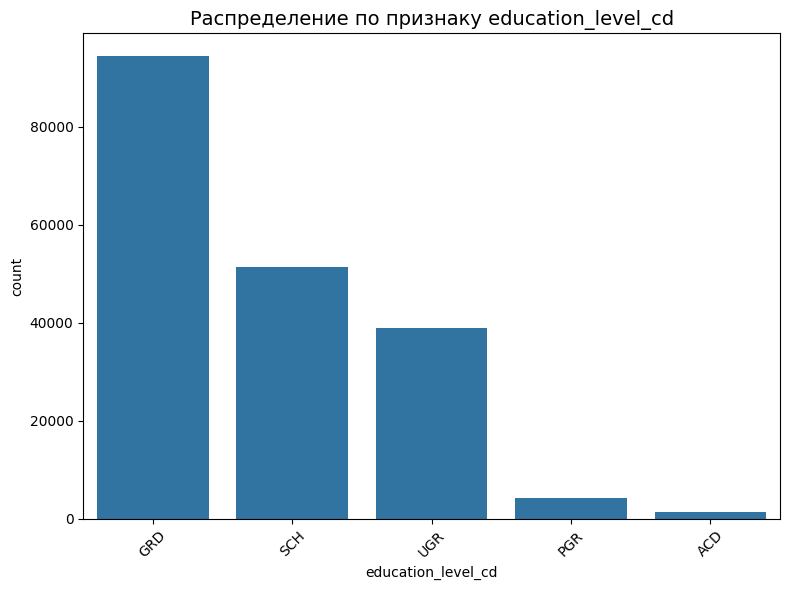

In [14]:
plot_categ(df, 'education_level_cd')

Информация о том, какой уровень образованности у клиентов, в основном отсутствует (206690 пропусков из 396749 строк, что составляет почти половину), поэтому анализ данной информации достаточно субъективен, но предварительно мы можем его всё равно сделать. В основном, самокатами пользуются люди с неоконченным высшим образованием (около 90 000 человек), меньше пользуются данным видом транспорта школьники (около 50 000 человек), следующее место занимают люди с оконченным высшим образованием (приблизительно 40 000 человек), ну и совсем немного людей с 2-мя высшими образованиями и ученой степенью (меньше 5 000 человек в каждой категории). Скорее всего, количество людей входящих в последние 2 категории так мало, потому что в целом такой уровень образования среди населения мало кто имеет. Тоже самое касается людей, которые имеют 2 высших образования, их в целом среди населения меньше. Школьников меньше, чем людей с высшим образованием, потому что есть ограничение по возрасту (ребенок должен быть старше 12 лет), при этом некоторые дети могут использовать для формирования поездки аккаунт своих родителей, а не собственный, что также может искуственно снизить количество людей в данной категории.  

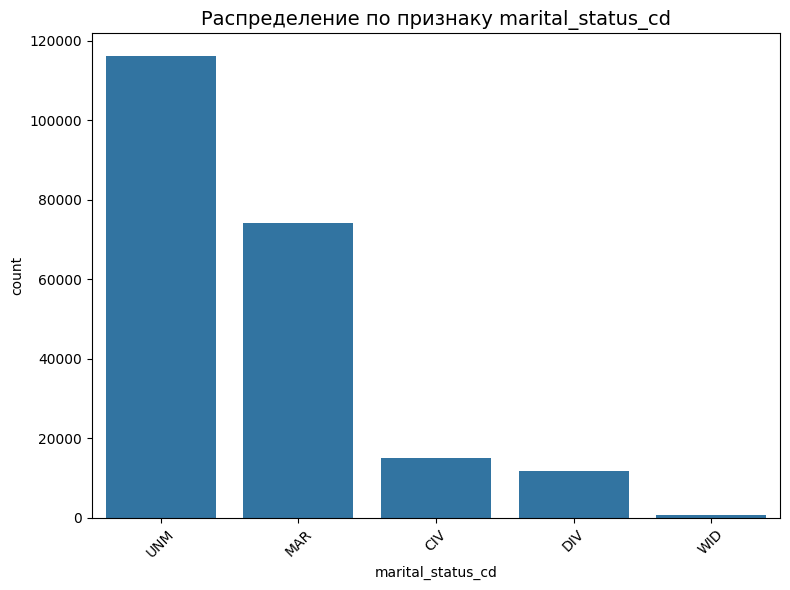

In [15]:
plot_categ(df, 'marital_status_cd')

Данная информация по семейному статусу человека также не совсем корректна, потому что пропузено больщое количество значений (179020 значений из 396749 строк, т.е. примерно половина). Мы видим на данном графике, что большую часть потребителей составляют люди, которые не состоят в отношениях (около 120 человек), те люди, которые состоят в браке, составляют следующую категорию, примерно, 80 000 человек. Далее идут пользователи, которые состоят в гражданском браке (около 20 000 человек), чуть меньше - люди в разводе (примерно,  15 000 человек), совсем малую часть пользователей составляют вдовцы (около 1500 человек). В целом, по этим данным можно только сказать, что процент вдов/цов в жизни небольшой, поэтому логично, что среди наших потребителей их тоже будет мало. И наоборот, людей, которые находятся без отношений, достаточно много по отношению в целом с населением (туда же будет входить больший процент школьников), поэтому на нашем графике их также много. 

In [16]:
# Проведем анализ числовых признаков
def plot_num_dist(df, col):
    plt.figure(figsize = (12, 6))
    sns.histplot(df[col], kde = True, bins = 40)
    plt.axvline(df[col].mean(), color = 'red', linestyle = '--', label = f'Среднее: {df[col].mean()}')
    plt.show()

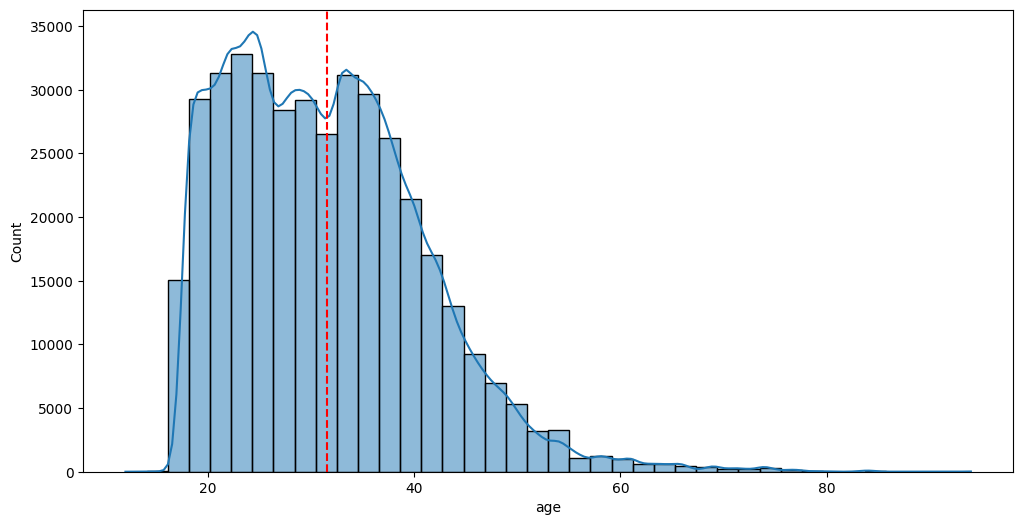

In [17]:
plot_num_dist(df, 'age')

На данном графике распределения количества пользователей в зависимости от возраста, мы видим логнормлаьное распределение, больше всего у нас пользователей самокатами от 20 до 40 лет, дальше количество пользователей более стращего возраста снижается. Есть вероятность, что пользователи 80-ти лет и более - это пользователи, которые могут скрывать свой настоящий возраст. 

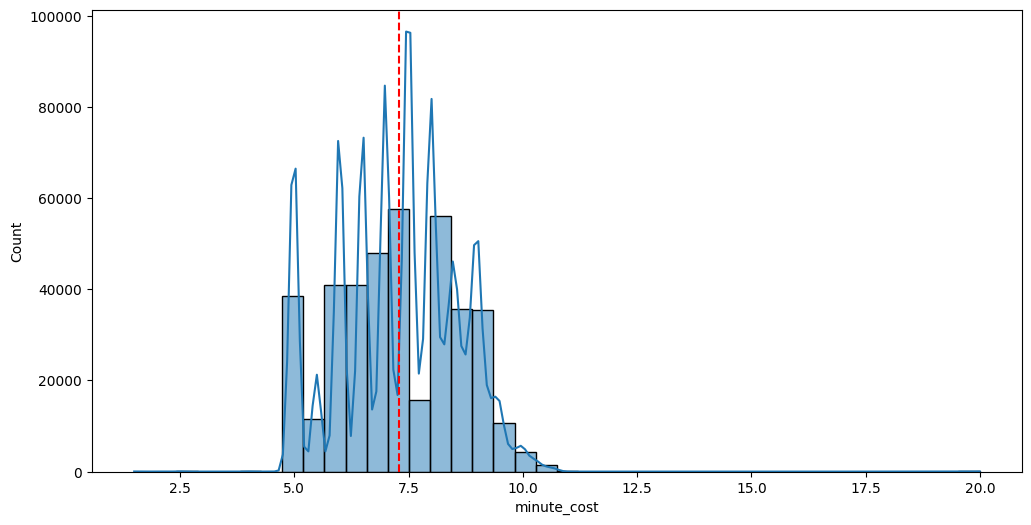

In [18]:
plot_num_dist(df, 'minute_cost')

График стоимости поездки за минуту больше принимает форму логнормального распределения с 3-мя вершинами. Мы видим некоторую тенденцию - чем меньше пользователей сейчас используют самокат, тем меньше стоимость за 1 минуту, с другой стороны, очень высокая стоимость (около 10 за 1 минуту) может снижать количество потребителей также. Стоимость за 1 минуту также может различаться от региона, в котором находится пользователь (чем крупнее город, тем выше может быть стоимость), возможно, километража, который проезжает пользователь за 1 поездку (например, чем дальше - тем меньше становится стоимость), также возможно наличие у пользователей каких-либо скидок на поездки от партнеров компании.

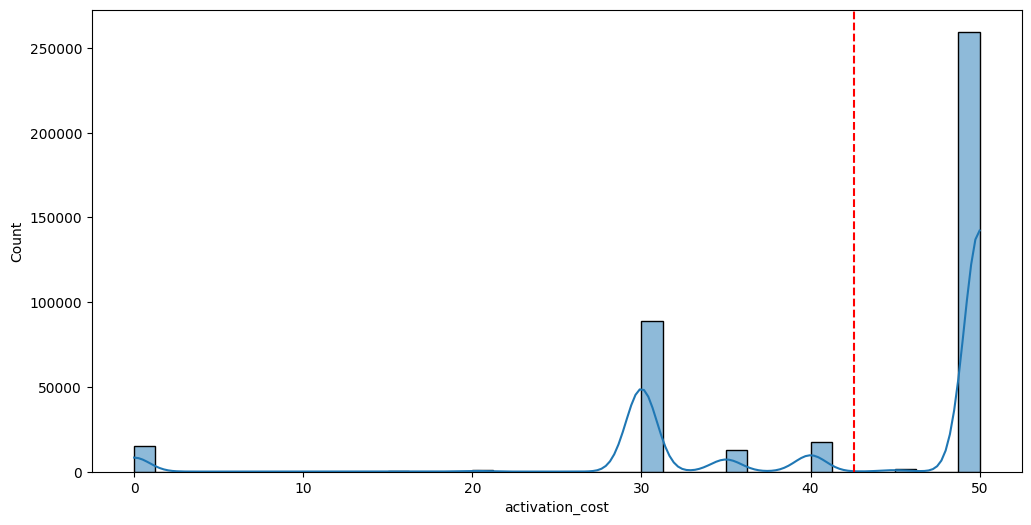

In [19]:
plot_num_dist(df, 'activation_cost')

На данном графике стоимости активации поездки мы модем увидеть, что чем выше спрос на самокаты, тем выше стоимость активации. Также, с учетом того, что у нас есть несколько пиков с небольшой стоимостью активации поездки при условии примерно одинаковой загрузки, могу предположить, что этот параметр также зависит от региона и, возможно, времени активации.

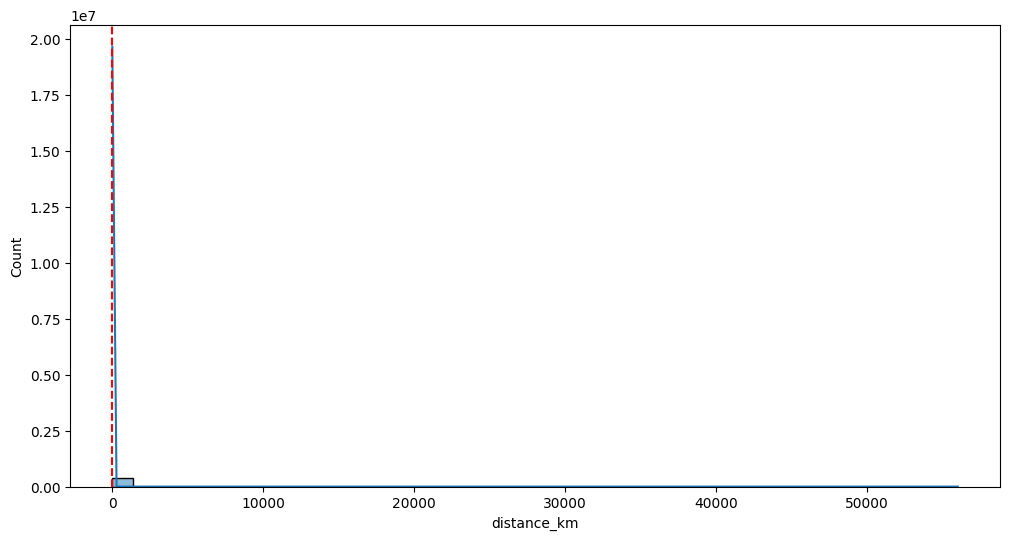

In [20]:
plot_num_dist(df, 'distance_km')

Данный график на дистанцию показывает, что в основном, пользователи используют самокат для передвижения на небольшие дистанции. Выброс в описательной статистики с 56 000 км - это, скорее всего, ошибка в единицах измерения. Построим ящик с усами для просмотра выбросов. 

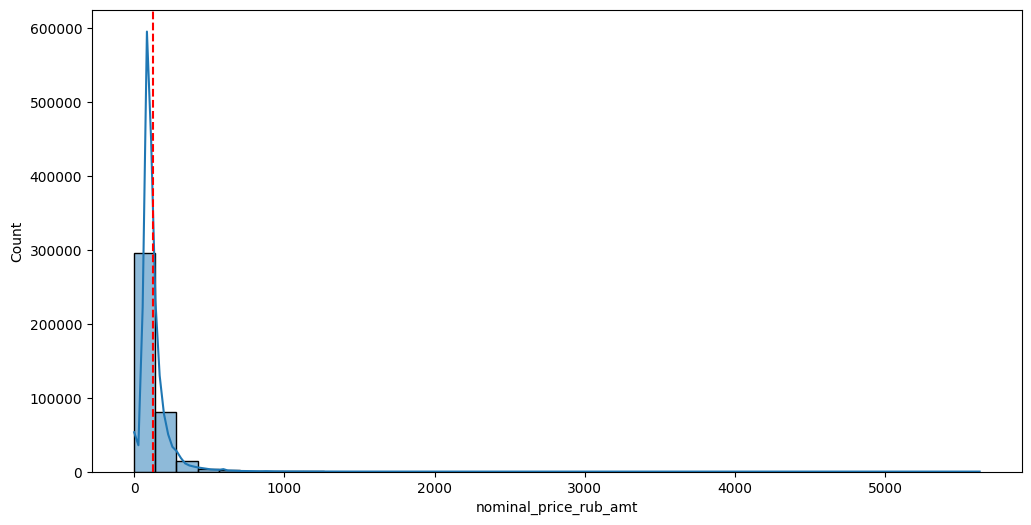

In [21]:
plot_num_dist(df, 'nominal_price_rub_amt')

График стоимости поездки показывает нам, что в основном, передвижение на самокате - достаточно бюджетное мероприятие, в среднем, стоимость составляет до 200 рублей. Более дорогие поездки крайне редки. По графику мы можем убедиться, что выброс в 56 000 из описательной статистики - это, скорее всего, ошибка. 

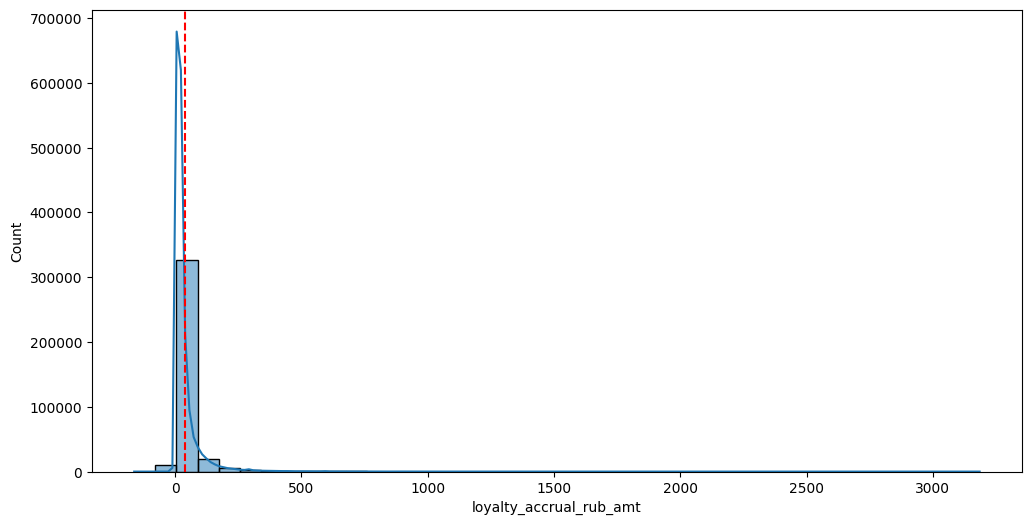

In [22]:
plot_num_dist(df, 'loyalty_accrual_rub_amt')

По графику денежного кэшбека мы также можем понять, что стоимость его небольшая в связи с тем, что сами поездки занимают немного финансов. Есть небольшая доля отрицательного кэшбека, я предполагаю, что это связано с нарушением использования сервиса, а также есть выброс в виде очень крупной суммы, которая, скорее всего, является возвратом средств. 

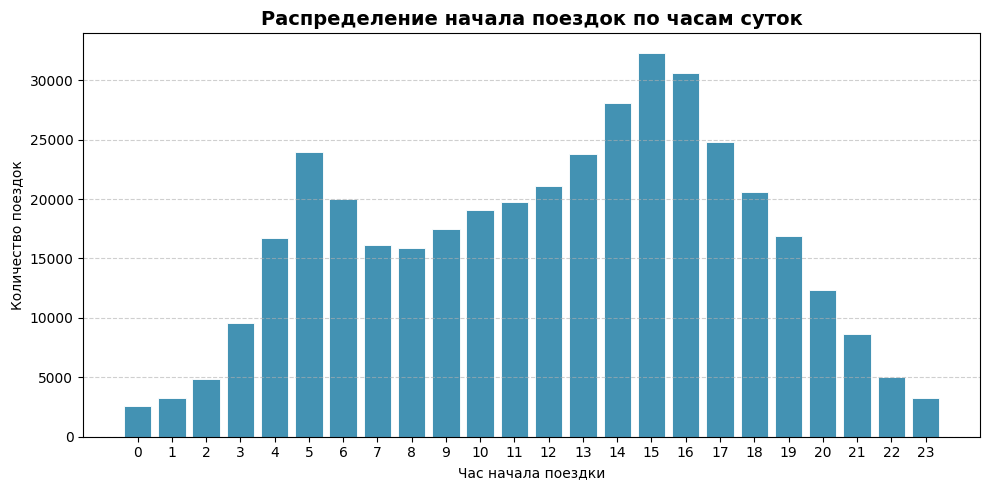

In [27]:
# Проведем анализ данных по дате и времени 
df['start_hour'] = df['book_start_dttm'].dt.hour
hour_counts = df['start_hour'].value_counts().reindex(range(24), fill_value=0).sort_index()
plt.figure(figsize=(10, 5))
plt.bar(hour_counts.index, hour_counts.values, 
        color='#2E86AB', edgecolor='white', linewidth=0.7, alpha=0.9)

plt.title('Распределение начала поездок по часам суток', fontsize=14, fontweight='bold')
plt.xlabel('Час начала поездки')
plt.ylabel('Количество поездок')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Можно заметить, что график старта поездок имеет нормальное распределение с двумя вершинами. Первая из них расположена в 5 утра, а вторая - в 15-16 часов, что говорит о том, что именно в эти часы чаще всего пользуются самокатами. Предположу, что в 5 утра могут чаще самокатами пользоваться люди, которые едут домой после ночных прогулок. Время 15-16 часов - когда студенты и школьники могут ехать домой с учёбы (т.к. большую часть нашей аудитории, возможно, составляет именно эти 2 контингента с учетом графика образованности).

In [23]:
# Проведем комплексную оценку корреляции 

categorical_cols = ['gender_cd', 'book_time_zone_cd']
numerical_cols = ['age', 'minute_cost', 'activation_cost', 'hold_amount', 'distance_km', 
                  'nominal_price_rub_amt', 'loyalty_accrual_rub_amt']
cols = categorical_cols + numerical_cols

phik_mat = df[cols].phik_matrix(njobs=1, verbose=True)  


interval columns not set, guessing: ['book_time_zone_cd', 'age', 'minute_cost', 'activation_cost', 'hold_amount', 'distance_km', 'nominal_price_rub_amt', 'loyalty_accrual_rub_amt']


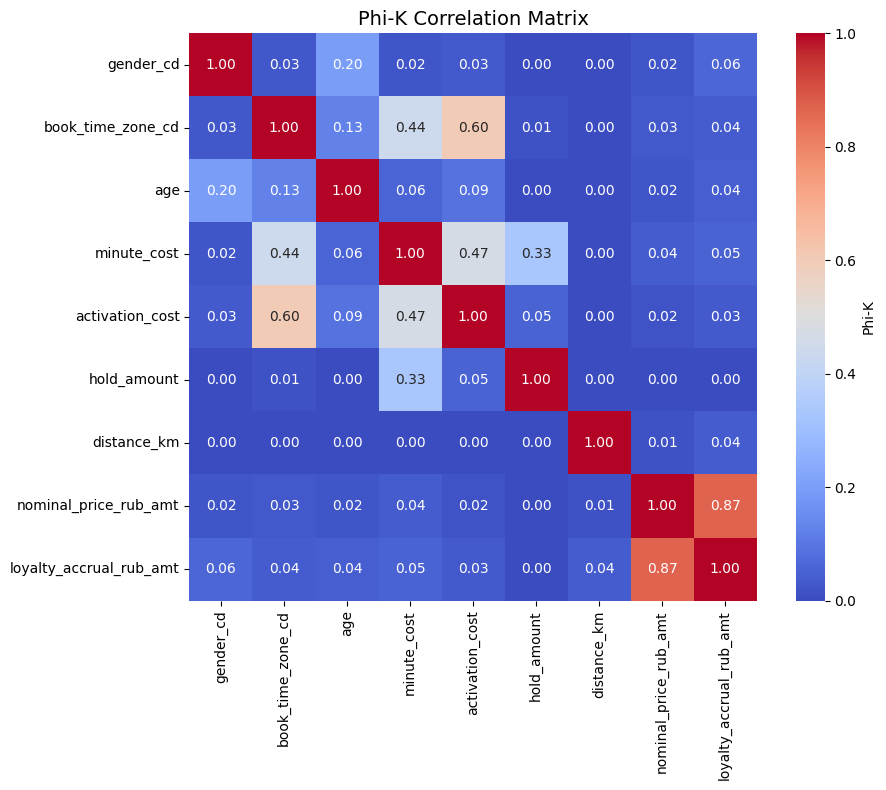

In [24]:
# Строим матрицу коррреляции
plt.figure(figsize=(10, 8))
sns.heatmap(phik_mat, annot=True, fmt='.2f', cmap='coolwarm', vmin=0, vmax=1,
    square=True, cbar_kws={'label': 'Phi-K'})
plt.title('Phi-K Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

По матрице корреляции мы можем увидеть, что большая часть показателей между собой совсем не коррелирует. Наиболее сильная положительная связь имеется между стоимостью аренды и кэшбеком, который получает пользователь, т.е. чем больше стоимость, тем больше будет кэшбек. Также мы видим, что имеется средняя положительная связь между стоимостью активации, стоимостью за 1 минуту и часового пояса (т.е. города), в котором сделан заказ, т.е. в городах, которые расположены в восточной части России скорее стоимость будет выше, чем для городов в западной части. При этом случаи обратной корреляции отсутствуют вовсе. 